<a href="https://colab.research.google.com/github/jyotidabass/Rotated-rectangle/blob/main/rotated_rectangle_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

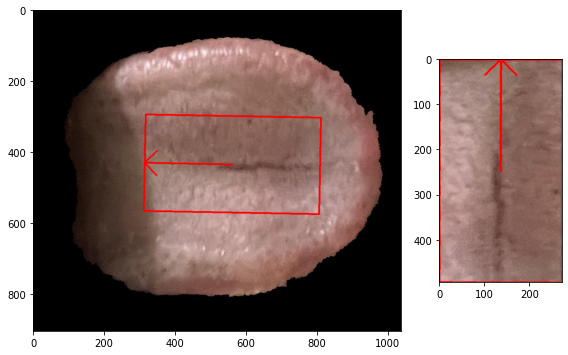

In [8]:

import cv2
import numpy as np


def inside_rect(rect, num_cols, num_rows):
    # Determine if the four corners of the rectangle are inside the rectangle with width and height
    # rect tuple
    # center (x,y), (width, height), angle of rotation (to the row)
    # center  The rectangle mass center.
    # center tuple (x, y): x is regarding to the width (number of columns) of the image, y is regarding to the height (number of rows) of the image.
    # size    Width and height of the rectangle.
    # angle   The rotation angle in a clockwise direction. When the angle is 0, 90, 180, 270 etc., the rectangle becomes an up-right rectangle.
    # Return:
    # True: if the rotated sub rectangle is side the up-right rectange
    # False: else

    rect_center = rect[0]
    rect_center_x = rect_center[0]
    rect_center_y = rect_center[1]

    rect_width, rect_height = rect[1]

    rect_angle = rect[2]

    if (rect_center_x < 0) or (rect_center_x > num_cols):
        return False
    if (rect_center_y < 0) or (rect_center_y > num_rows):
        return False

    # https://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
    box = cv2.boxPoints(rect)

    x_max = int(np.max(box[:,0]))
    x_min = int(np.min(box[:,0]))
    y_max = int(np.max(box[:,1]))
    y_min = int(np.min(box[:,1]))

    if (x_max <= num_cols) and (x_min >= 0) and (y_max <= num_rows) and (y_min >= 0):
        return True
    else:
        return False


def rect_bbx(rect):
    # Rectangle bounding box for rotated rectangle
    # Example: 
    # rotated rectangle: height 4, width 4, center (10, 10), angle 45 degree
    # bounding box for this rotated rectangle, height 4*sqrt(2), width 4*sqrt(2), center (10, 10), angle 0 degree

    box = cv2.boxPoints(rect)

    x_max = int(np.max(box[:,0]))
    x_min = int(np.min(box[:,0]))
    y_max = int(np.max(box[:,1]))
    y_min = int(np.min(box[:,1]))

    # Top-left
    # (x_min, y_min)
    # Top-right
    # (x_min, y_max)
    # Bottom-left
    #  (x_max, y_min)
    # Bottom-right
    # (x_max, y_max)
    # Width
    # y_max - y_min
    # Height
    # x_max - x_min
    # Center
    # (x_min + x_max) // 2, (y_min + y_max) // 2

    center = (int((x_min + x_max) // 2), int((y_min + y_max) // 2))
    width = int(x_max - x_min)
    height = int(y_max - y_min)
    angle = 0

    return (center, (width, height), angle)


def image_rotate_without_crop(mat, angle):
    # https://stackoverflow.com/questions/22041699/rotate-an-image-without-cropping-in-opencv-in-c
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    return rotated_mat

def crop_rectangle(image, rect):
    # rect has to be upright

    num_rows = image.shape[0]
    num_cols = image.shape[1]

    if not inside_rect(rect = rect, num_cols = num_cols, num_rows = num_rows):
        print("Proposed rectangle is not fully in the image.")
        return None

    rect_center = rect[0]
    rect_center_x = rect_center[0]
    rect_center_y = rect_center[1]
    rect_width = rect[1][0]
    rect_height = rect[1][1]


    return image[rect_center_y-rect_height//2:rect_center_y+rect_height-rect_height//2, rect_center_x-rect_width//2:rect_center_x+rect_width-rect_width//2]






def crop_rotated_rectangle(image, rect):
    # Crop a rotated rectangle from a image

    num_rows = image.shape[0]
    num_cols = image.shape[1]

    if not inside_rect(rect = rect, num_cols = num_cols, num_rows = num_rows):
        print("Proposed rectangle is not fully in the image.")
        return None

    rotated_angle = rect[2]

    rect_bbx_upright = rect_bbx(rect = rect)
    rect_bbx_upright_image = crop_rectangle(image = image, rect = rect_bbx_upright)

    rotated_rect_bbx_upright_image = image_rotate_without_crop(mat = rect_bbx_upright_image, angle = rotated_angle)

    rect_width = rect[1][0]
    rect_height = rect[1][1]

    crop_center = (rotated_rect_bbx_upright_image.shape[1]//2, rotated_rect_bbx_upright_image.shape[0]//2)

    return rotated_rect_bbx_upright_image[crop_center[1]-rect_height//2 : crop_center[1]+(rect_height-rect_height//2), crop_center[0]-rect_width//2 : crop_center[0]+(rect_width-rect_width//2)]



def crop_rotated_rectangle_test():
    # Test function for crop_rotated_rectangle(image, rect)

    import matplotlib.pylab as plt
    from matplotlib import gridspec
    import numpy as np

    # Better to test in Jupyter Notebook

    img = cv2.imread('/content/cropped-1E6AE7E2-F4F6-4EFC-AFEC-75B6AF988C47 - Abhishek Karekar.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #img = np.ones((1000, 1000), dtype=np.uint8)
    #img = cv2.line(img,(400,400),(511,511),2,120)
    #img = cv2.line(img,(300,300),(700,500),2,120)

    img_rows = img.shape[0]
    img_cols = img.shape[1]
    
    # Generate random rect
    
    while True:
        center = (np.random.randint(low = 1, high = img_cols), np.random.randint(low = 0, high = img_rows))
        width = np.random.randint(low = 1, high = img_cols)
        height = np.random.randint(low = 1, high = img_rows)
        angle = np.random.randint(low = 0, high = 360)
        rect = (center, (width, height), angle)
        if inside_rect(rect = rect, num_cols = img_cols, num_rows = img_rows):
            break
            
    #print(rect)

    box = cv2.boxPoints(rect).astype(np.int0)
    cv2.drawContours(img,[box],0,(255,0,0),3)
    cv2.arrowedLine(img, center, ((box[1][0]+box[2][0])//2,(box[1][1]+box[2][1])//2), (255,0,0), 3, tipLength = 0.2)

    image_cropped = crop_rotated_rectangle(image = img, rect = rect)
    '''
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(image_cropped)
    plt.show()
    '''
    
    # plot it
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.imshow(img)
    ax1 = plt.subplot(gs[1])
    ax1.imshow(image_cropped)

    plt.tight_layout()
    plt.savefig('demo.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return


if __name__ == '__main__':

    crop_rotated_rectangle_test()